In [3]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import mne
import time
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import signal


def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def string2timestamp(datetime_str):
    return time.mktime(datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').timetuple())


def string2obj(datetime_str):
    return datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')


def obj2string(datetime_obj):
    return datetime.datetime.strftime(datetime_obj, '%Y-%m-%d %H:%M:%S')


def obj2timestamp(datetime_obj):
    datetime_str = datetime.datetime.strftime(
        datetime_obj, '%Y-%m-%d %H:%M:%S')
    return time.mktime(datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').timetuple())


def timestamp2obj(timestamp):
    return datetime.datetime.utcfromtimestamp(timestamp-4*3600)


def timestamp2string(timestamp):
    datetime_obj = datetime.datetime.utcfromtimestamp(
        timestamp-4*3600)
    return datetime.datetime.strftime(datetime_obj, '%Y-%m-%d %H:%M:%S')


### Working

In [2]:
# readlines
f = open('data/test_Ganglion/OpenBCISession_Meditating4ch/OpenBCI-RAW-2023-02-27_18-48-11.txt', 'r')
line1 = f.readline()
line2 = f.readline()
line3 = f.readline()
line4 = f.readline()
num_channels = int(line2.strip().split()[-1])
print(num_channels)
sampling_frequency = int(line3.strip().split()[-2])
print(sampling_frequency)


4
200


In [3]:
raw_df = pd.read_csv(
    'data/test_Ganglion/OpenBCISession_Wk4ch/BrainFlow-RAW_Wk4ch_4.csv', delimiter='\t', header=None)
raw_df.dropna(inplace=True)
example_df = raw_df.iloc[:, [0,1,2,3,4,13]]
example_df.columns = ['Index_0','Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'timestamp']
example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]
example_df

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/2139202018.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]


,Index_0,Channel_1,Channel_2,Channel_3,Channel_4,timestamp
0,0.0,685.170241,582.470719,-369.148695,-265.622654,2023-02-27 18:24:18.258762
1,1.0,676.628310,602.458614,-424.057906,-366.072627,2023-02-27 18:24:18.272029
2,1.0,442.658299,658.968502,-190.187002,-572.120545,2023-02-27 18:24:18.272029
3,2.0,323.832327,563.266332,-227.112905,-608.126432,2023-02-27 18:24:18.289114
4,2.0,376.110519,748.726101,-193.796006,-612.386178,2023-02-27 18:24:18.289114
...,...,...,...,...,...,...
202185,90.0,295.291281,1945.658643,-296.749842,-724.360653,2023-02-27 18:41:09.170404
202186,91.0,277.530496,2096.561736,-180.373505,-615.890465,2023-02-27 18:41:09.186274
202187,91.0,244.658645,2059.583475,-112.475621,-509.931619,2023-02-27 18:41:09.186274
202188,92.0,441.160469,2123.935934,-102.321793,-521.162539,2023-02-27 18:41:09.186884


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/1475883263.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


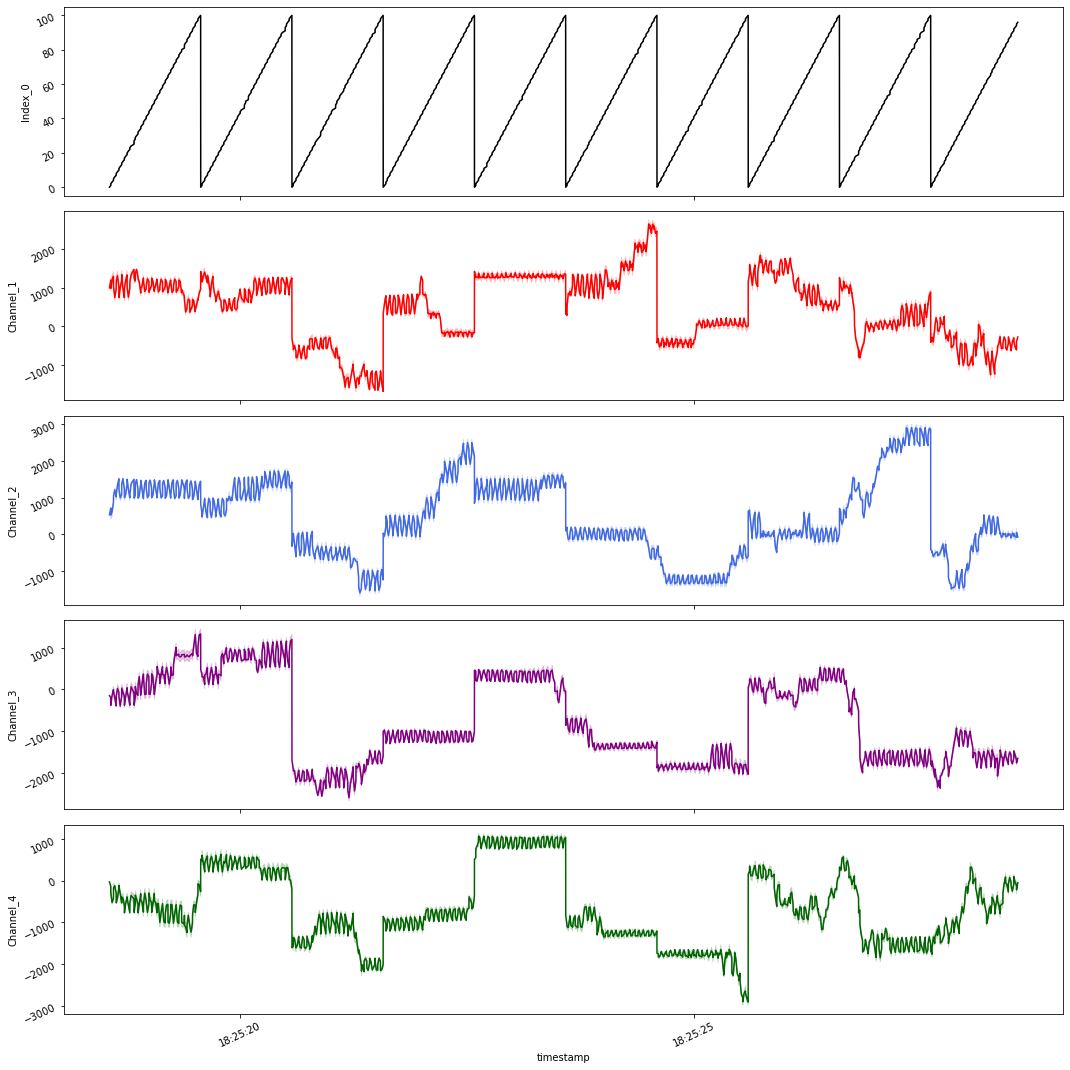

In [4]:
# df['imputed_filtered_BVP'] = hampel(df['filtered_BVP'], window_size=16, n=3, imputation=True)
import seaborn as sns
fig, ax = plt.subplots(5, 1,
                       figsize=(15, 15),
                       sharex=True)

color_list = ['black', 'red', "royalblue",
              "purple", 'darkgreen']
variable_names = ['Index_0',	'Channel_1',	'Channel_2',
		        	'Channel_3',	'Channel_4' ]

for i in range(5):
	ax[i].tick_params(labelrotation=25)
	sns.lineplot(x="timestamp", y=variable_names[i],
              color=color_list[i], data=example_df.loc[12060:14060, :],
              ax=ax[i])

fig.tight_layout(pad=1.2)
fig.show()
filename = 'Meditation_10_seconds_2.png'
plt.savefig(filename)


In [7]:
def detrend_raw_signal(ts, n_epochs=None, start=0, window=201):
    if not n_epochs:
        n_epochs = ts.shape // window
    ts = ts[start:(start+n_epochs*window)]
    ts_detrended = np.zeros((n_epochs*201,))
    end = start + 200
    for i in range(n_epochs):
        start += i*201
        end = start + 200
        y = ts[(i*201):(i*201+200)]
        x = np.linspace(0, 1.0, 200)
        m, b = np.polyfit(x, y, 1)
        d = y - x*m-b
        ts_detrended[(i*201):(i*201+200)] = d
    return ts_detrended
    

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/2365077916.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


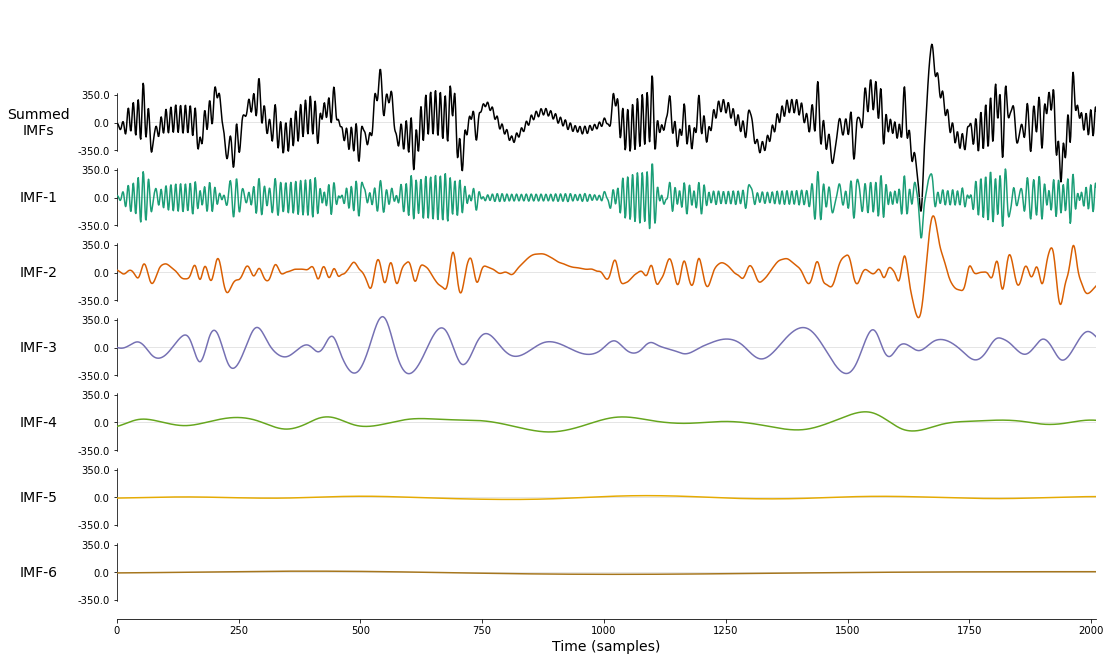

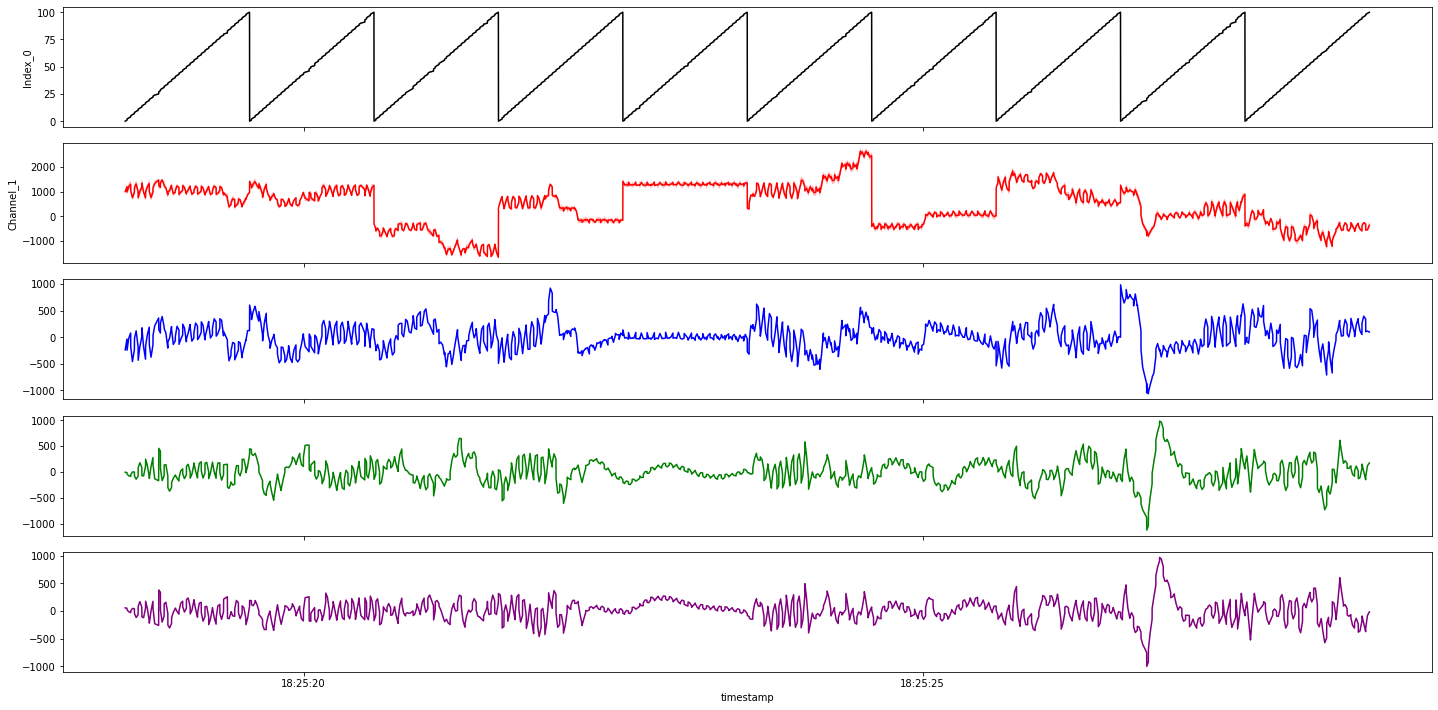

In [8]:
import emd
# 10 seconds
n_epochs = 10
start = 12060
low = 1
high = 24
window = 201
sos = signal.cheby2(N=10,
                    rs=40,
                    Wn=[low, high],
                    btype='bandpass',
                    fs=200,
                    output='sos')
detrended = detrend_raw_signal(
    example_df.loc[:, 'Channel_1'].to_numpy(),
    n_epochs=n_epochs,
    start=start,
    window=window)
filtered_detrended = signal.sosfilt(sos, detrended)
imf = emd.sift.sift(filtered_detrended)
emd.plotting.plot_imfs(imf)
reconstructed_signal = imf[:, 0] + imf[:, 1]

fig, ax = plt.subplots(5, 1,
                       figsize=(20, 10),
                       sharex=True)
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)
                              - 1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Index_0'],
             color='black', ax=ax[0])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Channel_1'],
             color='red', ax=ax[1])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=detrended,
             ci=None,
             color='blue', ax=ax[2])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=filtered_detrended,
             ci=None,
             color='green', ax=ax[3])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=reconstructed_signal,
             ci=None,
             color='purple', ax=ax[4])

fig.tight_layout(pad=1.2)
fig.show()
filename = 'Working_Channel_1_IMF1_2.png'
plt.savefig(filename)


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/318038458.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


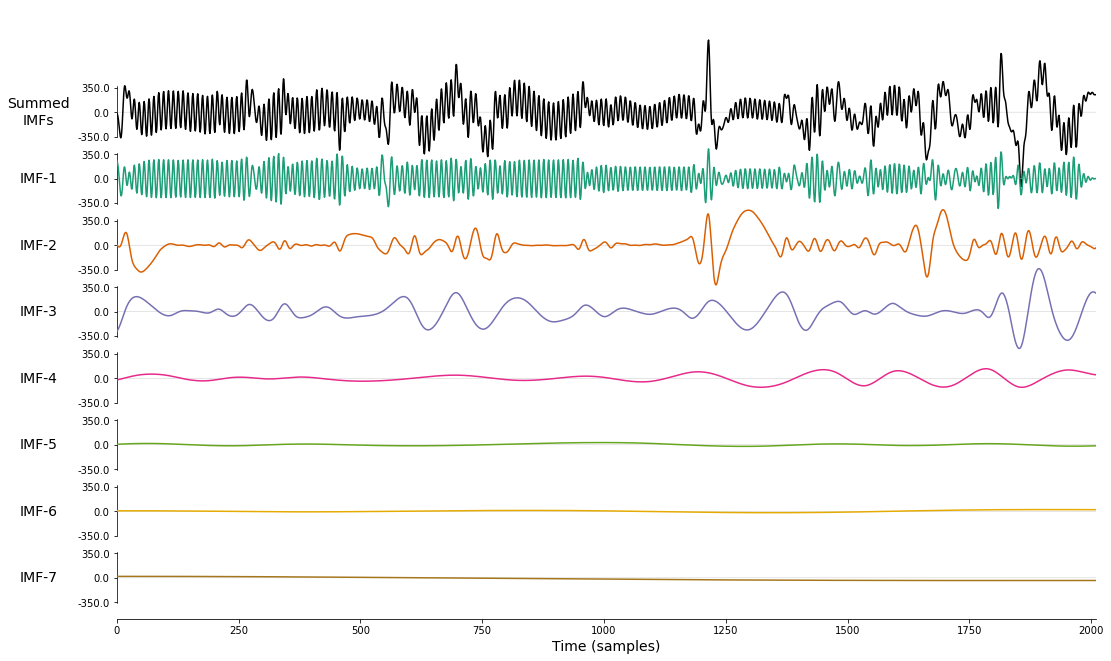

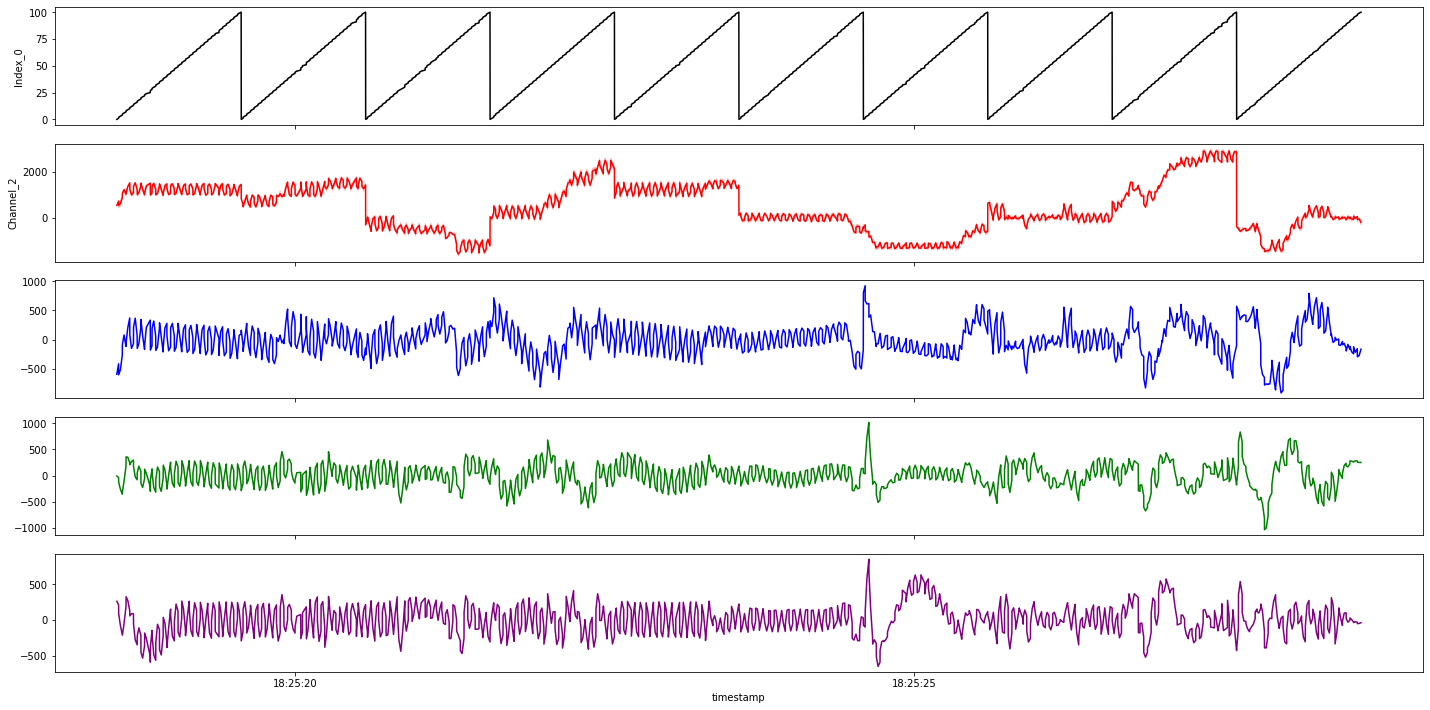

In [9]:
import emd
# 10 seconds
n_epochs = 10
start = 12060
low = 1
high = 24
sos = signal.cheby2(N=10,
                    rs=40,
                    Wn=[low, high],
                    btype='bandpass',
                    fs=200,
                    output='sos')
detrended = detrend_raw_signal(
    example_df.loc[:, 'Channel_2'].to_numpy(),
    n_epochs=n_epochs,
    start=start,
    window=window)
filtered_detrended = signal.sosfilt(sos, detrended)
imf = emd.sift.sift(filtered_detrended)
emd.plotting.plot_imfs(imf)
reconstructed_signal = imf[:, 0] + imf[:, 1]

fig, ax = plt.subplots(5, 1,
                       figsize=(20, 10),
                       sharex=True)
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)
                              - 1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Index_0'],
             color='black', ax=ax[0])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Channel_2'],
             color='red', ax=ax[1])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=detrended,
             ci=None,
             color='blue', ax=ax[2])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=filtered_detrended,
             ci=None,
             color='green', ax=ax[3])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=reconstructed_signal,
             ci=None,
             color='purple', ax=ax[4])

fig.tight_layout(pad=1.2)
fig.show()
filename = 'Working_Channel_2_IMF1_2.png'
plt.savefig(filename)


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/3782480631.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


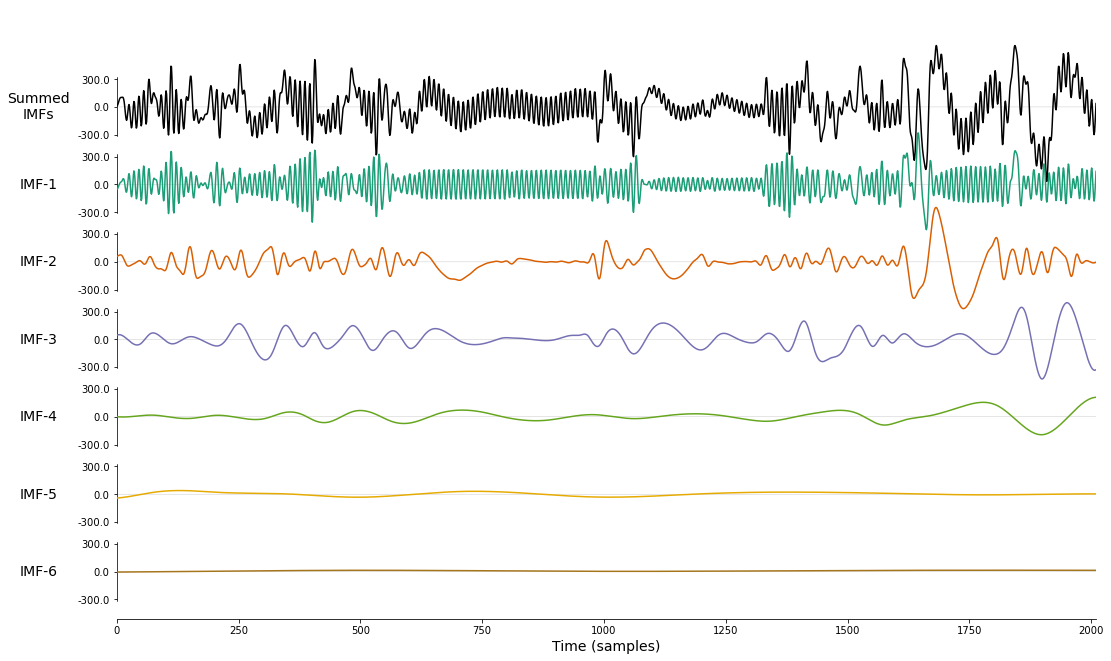

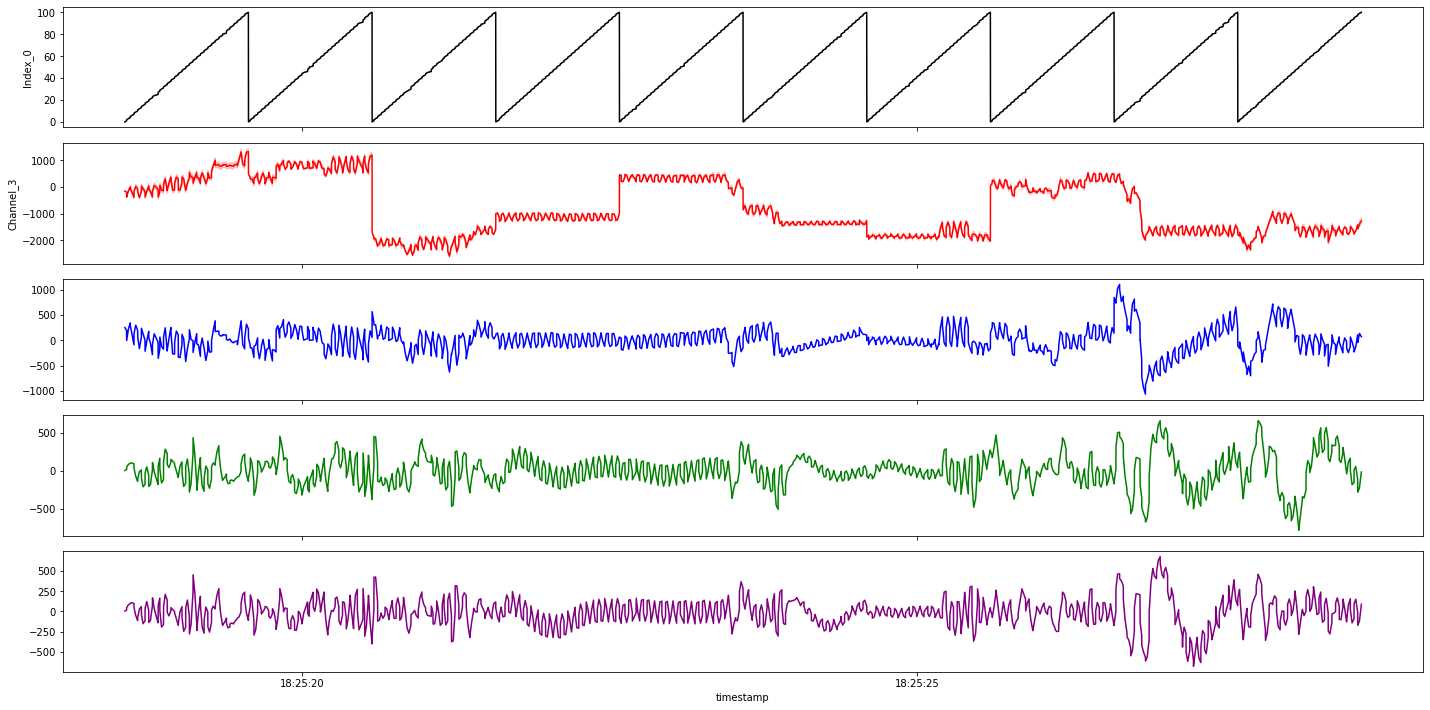

In [10]:
import emd
# 10 seconds
n_epochs = 10
start = 12060
low = 1
high = 24
sos = signal.cheby2(N=10,
                    rs=40,
                    Wn=[low, high],
                    btype='bandpass',
                    fs=200,
                    output='sos')
detrended = detrend_raw_signal(
    example_df.loc[:, 'Channel_3'].to_numpy(),
    n_epochs=n_epochs,
    start=start,
    window=window)
filtered_detrended = signal.sosfilt(sos, detrended)
imf = emd.sift.sift(filtered_detrended)
emd.plotting.plot_imfs(imf)
reconstructed_signal = imf[:, 0] + imf[:, 1]

fig, ax = plt.subplots(5, 1,
                       figsize=(20, 10),
                       sharex=True)
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)
                              - 1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Index_0'],
             color='black', ax=ax[0])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Channel_3'],
             color='red', ax=ax[1])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=detrended,
             ci=None,
             color='blue', ax=ax[2])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=filtered_detrended,
            ci=None,
            color='green', ax=ax[3])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=reconstructed_signal,
             ci=None,
             color='purple', ax=ax[4])

fig.tight_layout(pad=1.2)
fig.show()
filename = 'Working_Channel_3_IMF1_2.png'
plt.savefig(filename)


0.040891424554117366


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/1477238934.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


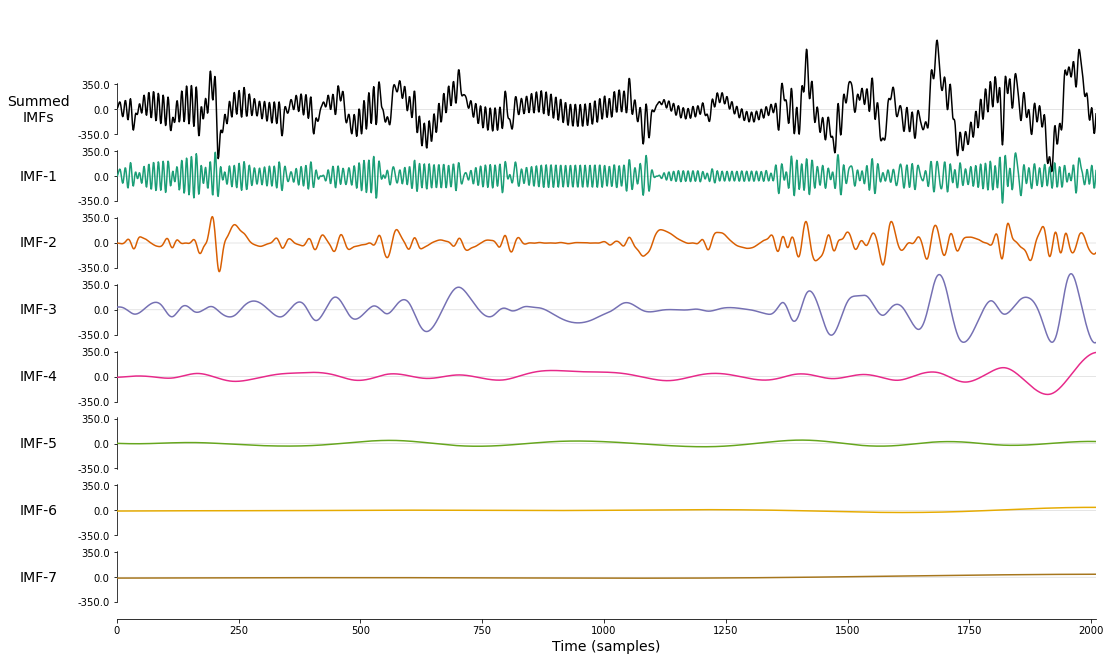

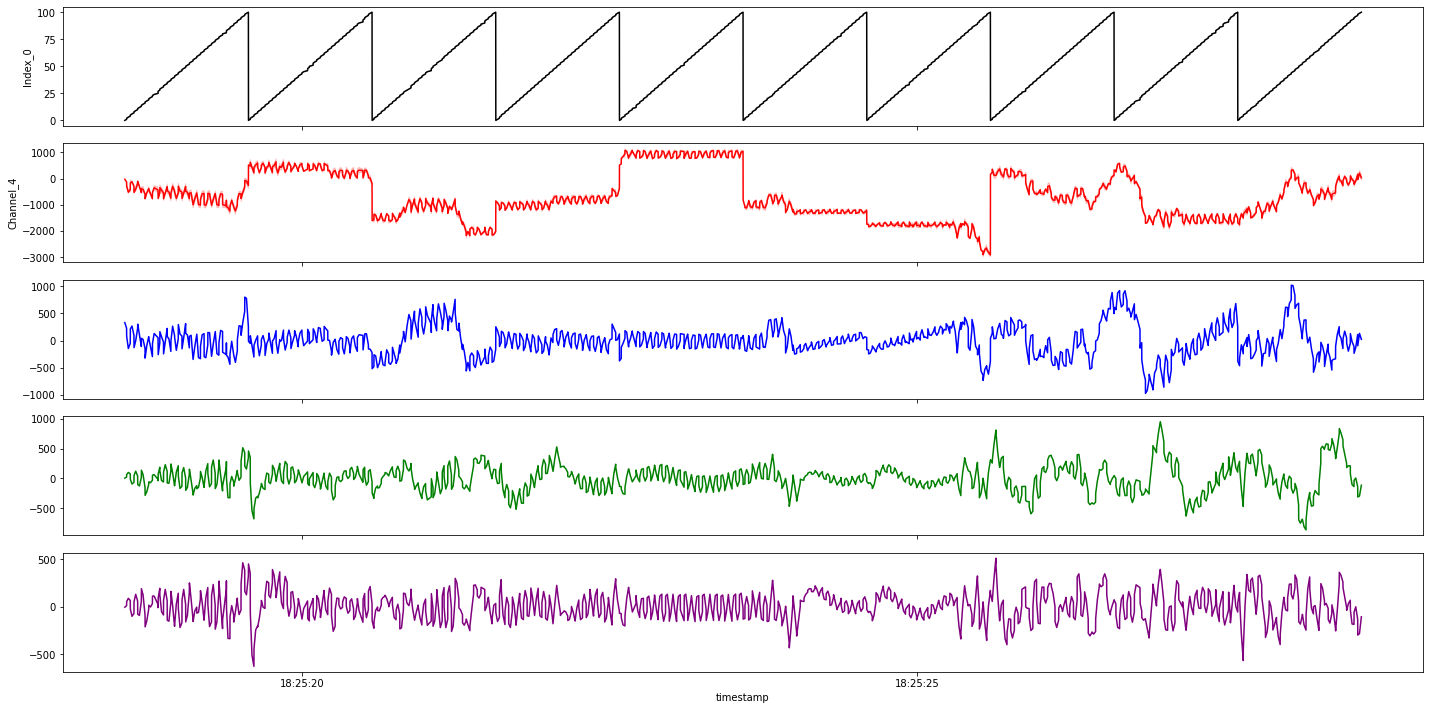

In [11]:
import emd
# 10 seconds
n_epochs = 10
start=12060
low = 1
high = 24
sos = signal.cheby2(N=10,
                    rs=40,
                    Wn=[low, high],
                    btype='bandpass',
                    fs=200,
                    output='sos')
detrended = detrend_raw_signal(
    example_df.loc[:, 'Channel_4'].to_numpy(),
    n_epochs=n_epochs,
    start=start,
    window=window)
filtered_detrended = signal.sosfilt(sos, detrended)
imf = emd.sift.sift(filtered_detrended)
emd.plotting.plot_imfs(imf)
reconstructed_signal = imf[:, 0] + imf[:, 1]
print(signaltonoise(reconstructed_signal))

fig, ax = plt.subplots(5, 1,
                       figsize=(20, 10),
                       sharex=True)
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)
                              - 1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Index_0'],
             color='black', ax=ax[0])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=example_df.loc[start:(start+201*n_epochs)-1, 'Channel_4'],
             color='red', ax=ax[1])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=detrended,
             ci=None,
             color='blue', ax=ax[2])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=filtered_detrended,
             ci=None,
             color='green', ax=ax[3])
sns.lineplot(x=example_df.loc[start:(start+201*n_epochs)-1, 'timestamp'],
             y=reconstructed_signal,
             ci=None,
             color='purple', ax=ax[4])

fig.tight_layout(pad=1.2)
fig.show()
filename = 'Working_Channel_4_IMF1_2.png'
plt.savefig(filename)




In [12]:
raw_df = pd.read_csv(
    'data/test_Ganglion/OpenBCISession_Wk4ch/BrainFlow-RAW_Wk4ch_4.csv', delimiter='\t', header=None)
raw_df.dropna(inplace=True)
example_df = raw_df.iloc[:, [0, 1, 2, 3, 4, 13]]
example_df.columns = ['Index_0', 'Channel_1',
                      'Channel_2', 'Channel_3', 'Channel_4', 'timestamp']
example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]

example_df

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/3463699616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]


,Index_0,Channel_1,Channel_2,Channel_3,Channel_4,timestamp
0,0.0,685.170241,582.470719,-369.148695,-265.622654,2023-02-27 18:24:18.258762
1,1.0,676.628310,602.458614,-424.057906,-366.072627,2023-02-27 18:24:18.272029
2,1.0,442.658299,658.968502,-190.187002,-572.120545,2023-02-27 18:24:18.272029
3,2.0,323.832327,563.266332,-227.112905,-608.126432,2023-02-27 18:24:18.289114
4,2.0,376.110519,748.726101,-193.796006,-612.386178,2023-02-27 18:24:18.289114
...,...,...,...,...,...,...
202185,90.0,295.291281,1945.658643,-296.749842,-724.360653,2023-02-27 18:41:09.170404
202186,91.0,277.530496,2096.561736,-180.373505,-615.890465,2023-02-27 18:41:09.186274
202187,91.0,244.658645,2059.583475,-112.475621,-509.931619,2023-02-27 18:41:09.186274
202188,92.0,441.160469,2123.935934,-102.321793,-521.162539,2023-02-27 18:41:09.186884


## Calculate metrics for entire recordings

In [4]:
def detrend_raw_signal(ts, n_epochs=None, start=0, window=201):
    if not n_epochs:
        n_epochs = ts.shape // window
    ts = ts[start:(start+n_epochs*window)]
    ts_detrended = np.zeros((n_epochs*201,))
    end = start + 200
    for i in range(n_epochs):
        start += i*201
        end = start + 200
        y = ts[(i*201):(i*201+200)]
        x = np.linspace(0, 1.0, 200)
        m, b = np.polyfit(x, y, 1)
        d = y - x*m-b
        ts_detrended[(i*201):(i*201+200)] = d
    return ts_detrended

In [5]:
# first mintue
start_index = np.where(example_df['Index_0'] == 0)[0][60]
minute_length = 201*60
minute_df = example_df.iloc[start_index:(start_index+minute_length), :]
minute_df = minute_df.reset_index(drop=True)
assert minute_df.loc[minute_df.shape[0]-1, 'Index_0'] == 100.0
minute_df

NameError: name 'example_df' is not defined

In [93]:
# 60 seconds
def channel_filtering(df, channel_name = 'Channel_1', plot_emd = False):
    n_epochs = 60
    start = 0
    low = 1
    high = 24
    sos = signal.cheby2(N=10,
                        rs=40,
                        Wn=[low, high],
                        btype='bandpass',
                        fs=200,
                        output='sos')
    detrended = detrend_raw_signal(
        minute_df.loc[:, channel_name].to_numpy(),
        n_epochs=n_epochs,
        start=start,
        window=window)
    filtered_detrended = signal.sosfilt(sos, detrended)
    imf = emd.sift.sift(filtered_detrended)
    if plot_emd:
        emd.plotting.plot_imfs(imf)
    reconstructed_signal = imf[:, 1] + imf[:, 2] + imf[:, 3]
    # reconstructed_signal = imf[:, 0] + imf[:, 1] + imf[:, 2]
    # reconstructed_signal = imf[:, 0] + imf[:, 1]
    return reconstructed_signal

In [94]:
minute_df['reconstructed_Channel_1'] = channel_filtering(
    minute_df, channel_name='Channel_1', 
#    plot_emd=True
    )
minute_df['reconstructed_Channel_2'] = channel_filtering(
    minute_df, channel_name='Channel_2', 
#    plot_emd=True
    )
minute_df['reconstructed_Channel_3'] = channel_filtering(
    minute_df, channel_name='Channel_3', 
#    plot_emd=True
    )
minute_df['reconstructed_Channel_4'] = channel_filtering(
    minute_df, channel_name='Channel_4', 
#    plot_emd=True
    )
minute_df

,Index_0,Channel_1,Channel_2,Channel_3,Channel_4,timestamp,reconstructed_Channel_1,reconstructed_Channel_2,reconstructed_Channel_3,reconstructed_Channel_4
0,0.0,995.696005,532.118576,-150.908703,-26.386864,2023-02-27 18:25:18.559367,-12.121495,-297.395173,104.593116,28.089816
1,1.0,1237.689971,744.305539,-186.634097,-170.034551,2023-02-27 18:25:18.573728,-14.926671,-296.490378,108.092249,28.801207
2,1.0,1152.240737,678.386063,-208.430234,-95.922824,2023-02-27 18:25:18.573728,-18.020157,-291.899741,111.744225,29.191591
3,2.0,929.830757,635.139730,-370.036921,-225.874998,2023-02-27 18:25:18.574426,-21.333665,-283.364801,115.251027,29.237367
4,2.0,1032.689225,416.727702,-395.881500,-347.674190,2023-02-27 18:25:18.574426,-24.798911,-270.627100,118.314664,28.914930
...,...,...,...,...,...,...,...,...,...,...
12055,98.0,507.685809,1816.604045,-2284.525368,-1222.403130,2023-02-27 18:26:18.830459,371.082934,-23.029253,-160.159061,-123.204078
12056,99.0,307.776937,1621.276550,-2487.055910,-1420.127901,2023-02-27 18:26:18.844024,378.860073,-46.219374,-202.184276,-177.855231
12057,99.0,525.800015,1824.014657,-2258.280620,-1212.438167,2023-02-27 18:26:18.844024,375.399919,-64.277284,-237.750315,-224.456569
12058,100.0,769.574173,2042.832463,-2503.025283,-1425.098228,2023-02-27 18:26:18.859843,361.531959,-75.214876,-262.816296,-256.874485


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_1244/713744522.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


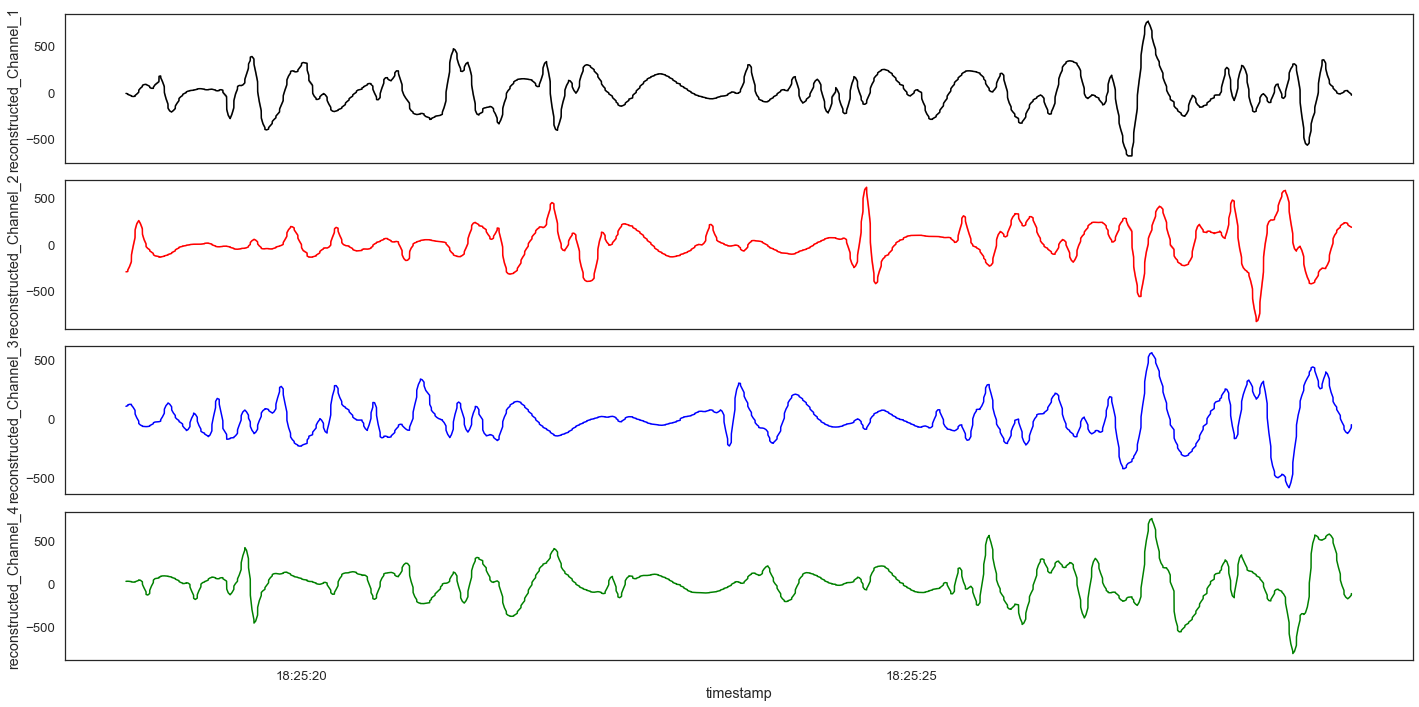

In [95]:
end_index = 2010
fig, ax = plt.subplots(4, 1,
                       figsize=(20, 10),
                       sharex=True)
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'reconstructed_Channel_1'],
             color='black', ax=ax[0])
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'reconstructed_Channel_2'],
             color='red', ax=ax[1])
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'reconstructed_Channel_3'],
             ci=None,
             color='blue', ax=ax[2])
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'reconstructed_Channel_4'],
             ci=None,
             color='green', ax=ax[3])

fig.tight_layout(pad=1.2)
fig.show()
filename = 'Working_all_reconstructed_Channels_234.png'
plt.savefig(filename)


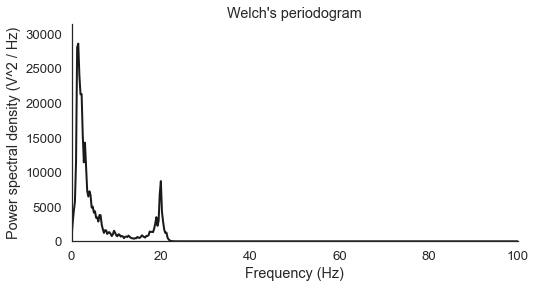

In [79]:
# calculate features
from scipy import signal
sf = 200

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(
    minute_df['reconstructed_Channel_4'], sf, nperseg=win)
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()


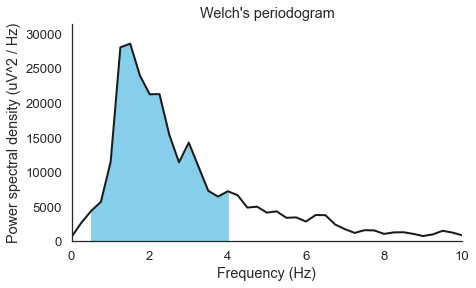

In [83]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()


In [84]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)


Absolute delta power: 53313.705 uV^2


In [85]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)


Relative delta power: 0.612


In [26]:
# by every next minute
next_start_index = np.where(example_df['Index_0'] == 0)[0][60]
next_start_index


12060

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

# Define the duration of the window to be 4 seconds
win_sec = 4

# Delta/beta ratio based on the absolute power
db = bandpower(data, sf, [0.5, 4], win_sec) / \
    bandpower(data, sf, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], win_sec, True) / \
    bandpower(data, sf, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)
